# Generalised Tight-Binding Equation Solver for BiTeI
George Bird 25/10/22

In [1]:
# Load Dependencies
import numpy as np
import pickle
import matplotlib.pyplot as plt

#### Loading the datasets into an array for further use:

In [2]:
# This method loads the matrix of hoppings
def load_hoppings(filepath):
    """
    Given the filepath, it loads all the relevant complex hoppings into a matrix of shape [Rx, Ry, Rz, Pi, Pj] and normalises
    using the weights.
    :param filepath: String of filepath e.g. BiTeI_hr_trivial.dat
    """
    # Load relevant information from the file
    with open(filepath, "r") as f:
        filetext = f.read()
        weights = filetext.split("\n")[3:80]
        dataset = filetext.split("\n")[80:-1]
        
    # The dataset reads [Rx, Ry, Rz Pi, Pj, T_real, T_imag], here all possible Rx, Ry and Rz values are determined and
    # are stored in sets
    Rx_values = {int(datapoint.split("   ")[1]) for datapoint in dataset}
    Ry_values = {int(datapoint.split("   ")[2]) for datapoint in dataset}
    Rz_values = {int(datapoint.split("   ")[3]) for datapoint in dataset}
    # The minimum and maximum values from these sets are then determined, they are stacked into a list for simplicity
    R_list = [Rx_values, Ry_values, Rz_values]
    # Minimum values
    Rx_min, Ry_min, Rz_min = [min(R) for R in R_list]
    Rx_max, Ry_max, Rz_max = [max(R) for R in R_list]
    
    # Then the weights are seperated out, they are already seperated by row, so they are now further seperated by column
    # and appended into a list. Despite being integers, they are stored as float so that wrong types do not later occur
    weight_list = []
    for weight_row in weights:
        weight_list += [float(weight) for weight in weight_row.split("   ")[1:]]
    
    # Finally the hoppings are stored in a matrix. This matrix is stored below
    hoppings = np.zeros((Rx_max-Rx_min+1, Ry_max-Ry_min+1, Rz_max-Rz_min+1, 18, 18), dtype=np.complex128)
    # There are 1155 weights, which correspond in order to the unique combinations of Rx, Ry, Rz.
    # Thus the unique combinations of Rx, Ry, Rz are stored as an ordered list below
    unique_offsets = [] 
    # Unpack dataset and load hoppings into the matrix
    for datapoint in dataset:
        # Determine the indexings
        Rx, Ry, Rz, Pi, Pj = [int(i) for i in datapoint.split("   ")[1:6]]

        # No repeat entries are wanted in the unique offsets, so in effect an ordered set is generated
        if [Rx, Ry, Rz] not in unique_offsets:
            unique_offsets.append([Rx, Ry, Rz])
        # Then the specific weight is looked up for the current combination of Rx, Ry, Rz
        weights_factor = weight_list[unique_offsets.index([Rx, Ry, Rz])]

        # Represent the hopping as a complex number
        T = float(datapoint.split("   ")[-2]) + 1j*float(datapoint.split("   ")[-1])
        # Fill the corresponding element of the array
        hoppings[Rx-Rx_min, Ry-Ry_min, Rz-Rz_min, Pi-1, Pj-1] = T/weights_factor
    
    # Finally return the hoppings and the respective combinations of Rx, Ry and Rz such that the fourier-like transform
    # can be performed later
    return hoppings, R_list

In [3]:
MAKE_FILES = False
if MAKE_FILES:
    # Load Datasets
    trivial_hoppings, trivial_R = load_hoppings("BiTeI_hr_trivial.dat")
    topological_hoppings, topological_R = load_hoppings("BiTeI_hr_topological.dat")
    # Export Datasets
    pickle.dump([trivial_hoppings, trivial_R], open("BiTeI_hr_trivial.pickle", "wb"))
    pickle.dump([topological_hoppings, topological_R], open("BiTeI_hr_topological.pickle", "wb"))
else:
    # Import Datasets
    trivial_hoppings, trivial_R = pickle.load(open("BiTeI_hr_trivial.pickle", "rb"))
    topological_hoppings, topological_R = pickle.load(open("BiTeI_hr_topological.pickle", "rb"))

#### Determining the energy bands from the supplied hoppings using the tight-binding equation:

In [4]:
def determine_band_structures(hoppings, R_values, k_vectors):
    """
    This method finds the band structure for the specified hoppings, at specific reciprocal lattice space positions.
    :param hoppings: The matrix produced by "load_hoppings" method.
    :param R_values: These are also produced as output of the "load hoppings" method.
    :param k_vectors: This is a matrix of k_vector positions in shape [positions, 3].
    """
    # A placeholder matrix is created to store the tight-binding hamiltonians
    number_of_kpositions = k_vectors.shape[0]
    TB_hamiltonian = np.zeros((number_of_kpositions, hoppings.shape[3], hoppings.shape[4]), dtype=np.complex128)
    
    # Produce the tight-matrix by summing over the Rx, Ry, Rz values with the respective phases
    for x in range(hoppings.shape[0]):
        for y in range(hoppings.shape[1]):
            for z in range(hoppings.shape[2]):
                R_values = [sorted(list(R)) for R in R_values]
                # Arrange them as an ordered list
                R_vector = np.array([R_values[0][x], R_values[1][y], R_values[2][z]]).reshape(1, 3) # Vector [Rx, Ry, Rz]
                # Find the associated phase factor
                phase_factor = np.exp(1j*np.multiply(R_vector, k_vectors).sum(axis=1)).reshape(-1, 1, 1)
                # Obtain the relevant slice of the hopping terms
                hopping_slice = hoppings[x, y, z, ::].reshape(1, hoppings.shape[3], hoppings.shape[4])
                # Perform the weighted sum of hoppings with their phase factors
                TB_hamiltonian += np.multiply(hopping_slice, phase_factor)
    
    # For every position in K-space determine the eigenvalues:
    # Energy bands is a list containing [K_vector, [ordered eigenvalues], [ordered eigenvectors]]
    energy_bands = []
    for i in range(number_of_kpositions):
        # Eigenvector decomposition
        u, s, v = np.linalg.svd(TB_hamiltonian[i, ::])
        eigenvalues = [i.real for i in s]
        eigenvectors = [u[:, i].real.reshape(-1, 1) for i in range(u.shape[0])]  
        
        # Order the list of eigen value-vector pairs to clearly express bands
        eigenvalues, eigenvectors = zip(*sorted(zip(eigenvalues, eigenvectors), key=lambda x: x[0]))
        # Append to the list
        energy_bands.append([k_vectors[i, :], eigenvalues, eigenvectors])    
    return energy_bands
        

#### Graph energy bands:

In [5]:
# K-space Positions
H = np.array([0, np.pi, np.pi])
A = np.array([0, 0, np.pi])
L = np.array([np.pi, 0, np.pi])

In [6]:
interpolation_parameter = 1 # 0 trivial to 1 topological
# Produce linearly interpolated hopping values
interpolated_hoppings = (1-interpolation_parameter)*trivial_hoppings+interpolation_parameter*topological_hoppings

# Produce a series of positions in K-space, by linearly interpolating between positions
samples = 100
k_space_positions = [H, A, L]

# Interpolate between these positions
K_vectors = []
for i in range(1, len(k_space_positions)):
    for j in range(samples+1):
        point = (1-j/samples)*k_space_positions[i-1] + (j/samples)*k_space_positions[i]
        K_vectors.append(point)
K_vectors = np.array(K_vectors)

In [7]:
# Deduce the bands
energy_bands = determine_band_structures(interpolated_hoppings, trivial_R, K_vectors)

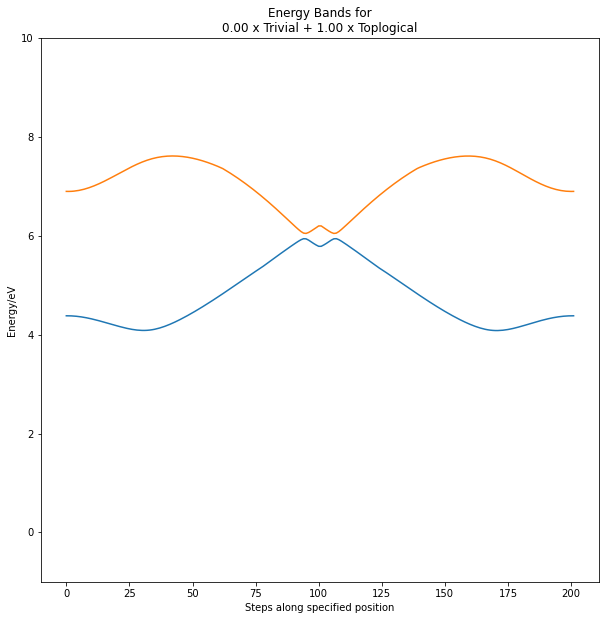

In [8]:
# Plot the graph
fig, ax = plt.subplots(1, figsize=(10, 10))
eigenvalues = np.array([energy_bands_at_k[1] for energy_bands_at_k in energy_bands])

for band in range(eigenvalues.shape[1]):
    if band == 11 or band ==12:
        ax.plot(eigenvalues[:, band])
ax.set_ylim(-1, 10)
ax.set_ylabel("Energy/eV")
ax.set_xlabel("Steps along specified position")
ax.set_title(f"Energy Bands for\n{1-interpolation_parameter:3.2f} x Trivial + {interpolation_parameter:3.2f} x Toplogical")
    
plt.show()

# Band number 12 and 13, 6 P electrons for tellurium and iodide, remaining 6 bands from bismuth
# Z2 index
# Gradient descent
# Begin thesis 20pages (presentation is the main thing)